<a href="https://www.kaggle.com/code/himanshunakrani/gold-price-prediction-project?scriptVersionId=104030753" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Import Libraries
---

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.ensemble import ExtraTreesRegressor

In [2]:
pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)

import warnings
warnings.filterwarnings("ignore")

sns.set_style("darkgrid")

# import data
---

In [3]:
data = pd.read_csv('../input/gold-price-data/gld_price_data.csv')

In [4]:
data.head()

,Date,SPX,GLD,USO,SLV,EUR/USD
0,1/2/2008,1447.160034,84.860001,78.470001,15.180,1.471692
1,1/3/2008,1447.160034,85.570000,78.370003,15.285,1.474491
2,1/4/2008,1411.630005,85.129997,77.309998,15.167,1.475492
3,1/7/2008,1416.180054,84.769997,75.500000,15.053,1.468299
4,1/8/2008,1390.189941,86.779999,76.059998,15.590,1.557099


# Exploratory Data Analysis
---

### Statistical Analysis

In [5]:
data.shape

(2290, 6)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2290 entries, 0 to 2289
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Date     2290 non-null   object 
 1   SPX      2290 non-null   float64
 2   GLD      2290 non-null   float64
 3   USO      2290 non-null   float64
 4   SLV      2290 non-null   float64
 5   EUR/USD  2290 non-null   float64
dtypes: float64(5), object(1)
memory usage: 107.5+ KB


In [7]:
data.isna().sum()

Date       0
SPX        0
GLD        0
USO        0
SLV        0
EUR/USD    0
dtype: int64

In [8]:
data.describe()

,SPX,GLD,USO,SLV,EUR/USD
count,2290.000000,2290.000000,2290.000000,2290.000000,2290.000000
mean,1654.315776,122.732875,31.842221,20.084997,1.283653
std,519.111540,23.283346,19.523517,7.092566,0.131547
min,676.530029,70.000000,7.960000,8.850000,1.039047
25%,1239.874969,109.725000,14.380000,15.570000,1.171313
50%,1551.434998,120.580002,33.869999,17.268500,1.303297
75%,2073.010070,132.840004,37.827501,22.882500,1.369971
max,2872.870117,184.589996,117.480003,47.259998,1.598798


In [9]:
data.duplicated().sum()

0

In [10]:
data.nunique()

Date       2290
SPX        2277
GLD        1930
USO        1514
SLV        1331
EUR/USD    2066
dtype: int64

### Visualization Analysis

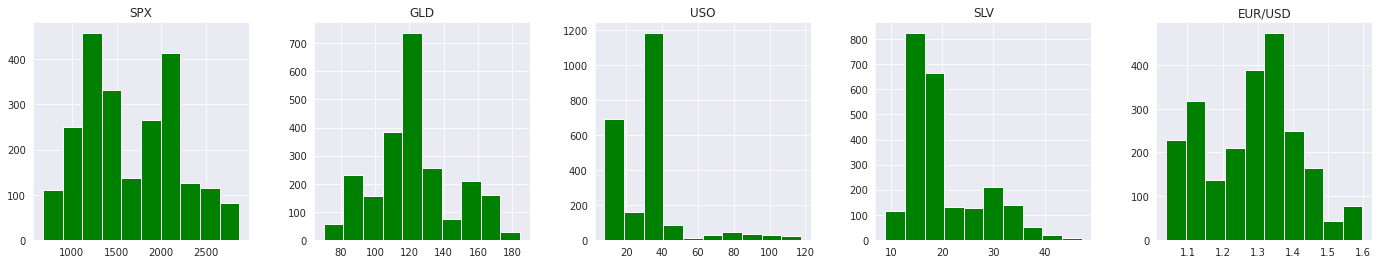

In [11]:
data.hist(figsize=(24,4), layout=(1,5), color="g");

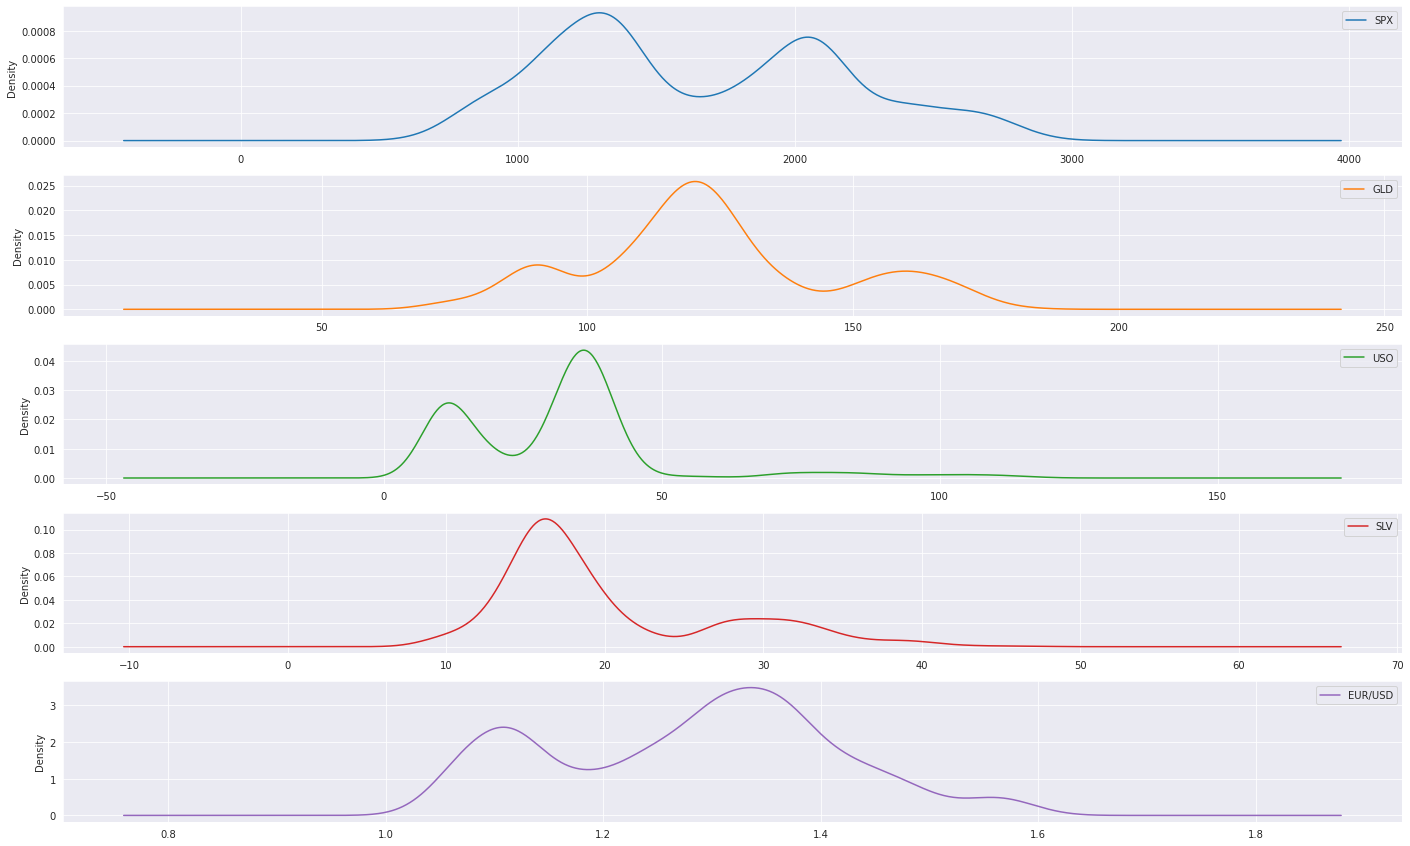

In [12]:
data.plot(kind="kde", subplots=True, layout=(5,1), figsize=(24,15),sharex=False, sharey=False);

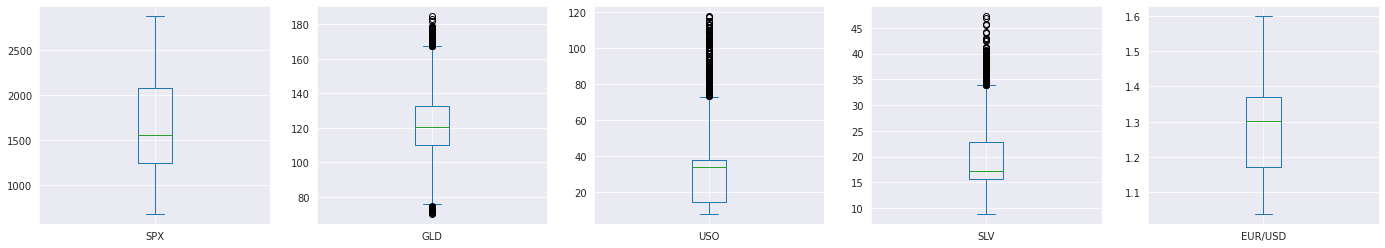

In [13]:
data.plot(kind="box", subplots=True, layout=(1,5), figsize=(24,4),sharex=False, sharey=False);

### Multivariate

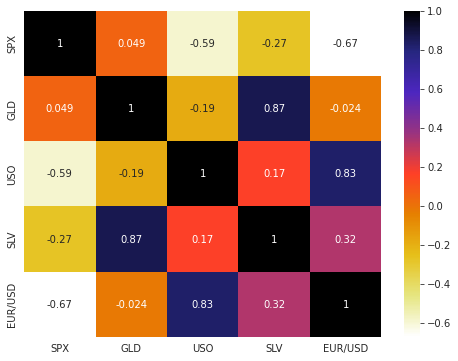

In [14]:
plt.figure(figsize=(8,6))
sns.heatmap(data.corr(), annot=True, cmap=plt.cm.CMRmap_r);

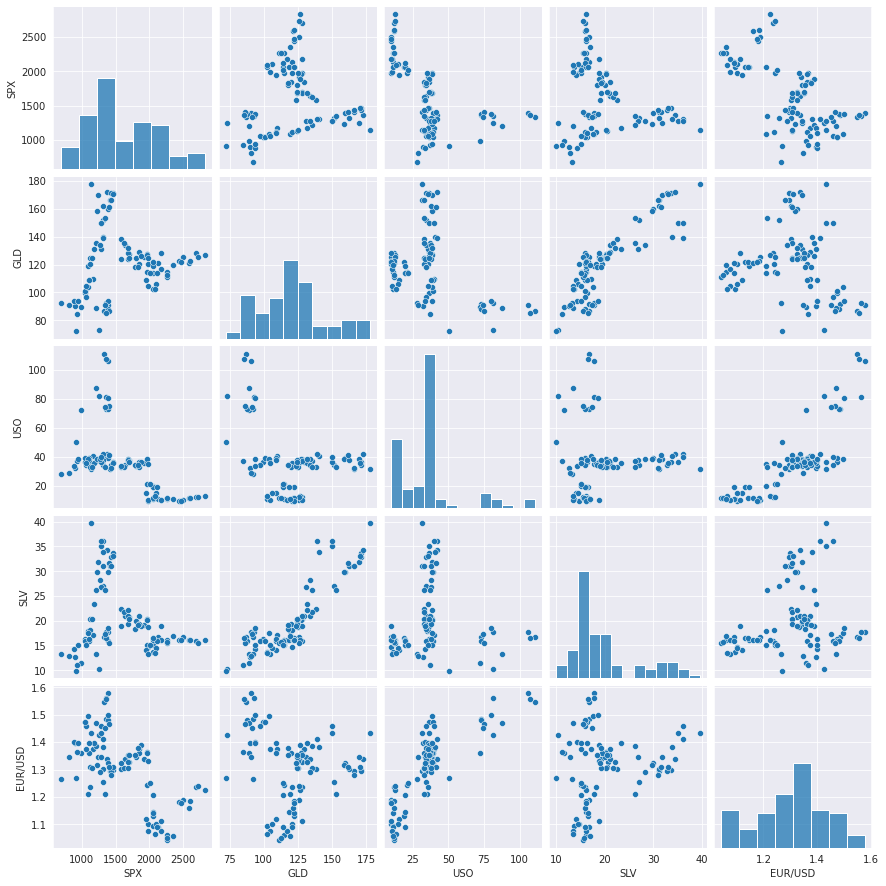

In [15]:
sns.pairplot(data.sample(n=100));

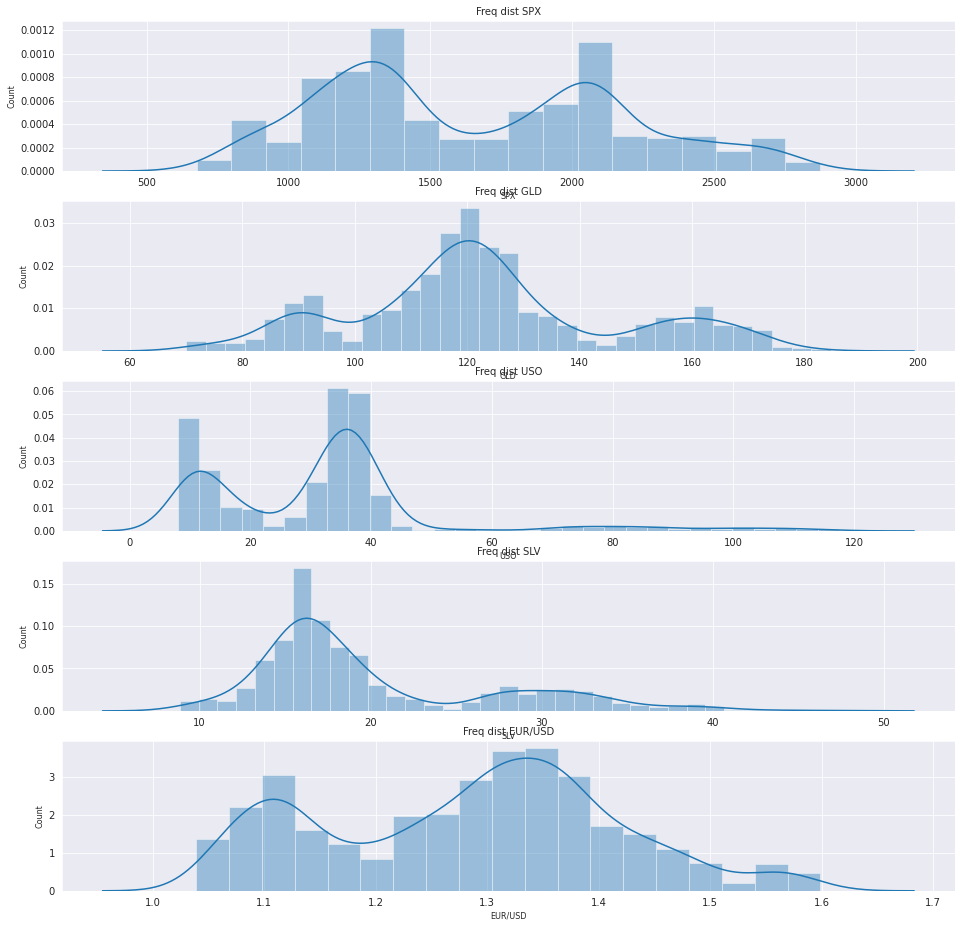

In [16]:
col_names = ['SPX','GLD', 'USO', 'SLV', 'EUR/USD']

fig, ax = plt.subplots(len(col_names), figsize=(16,16))

for i, col_val in enumerate(col_names):

    sns.distplot(data[col_val], hist=True, ax=ax[i])
    ax[i].set_title('Freq dist '+col_val, fontsize=10)
    ax[i].set_xlabel(col_val, fontsize=8)
    ax[i].set_ylabel('Count', fontsize=8)

plt.show()

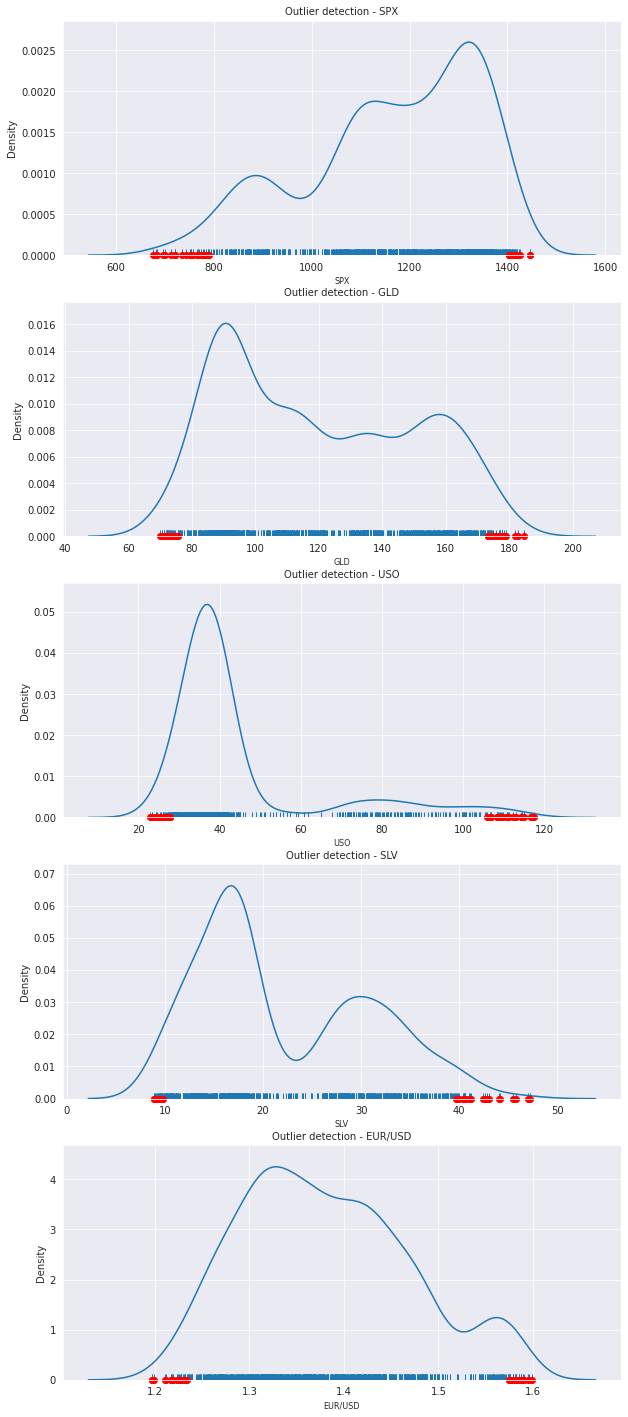

In [17]:
def percentile_based_outlier(data, threshold=95):
    diff = (100 - threshold) / 2
    minval, maxval = np.percentile(data, [diff, 100 - diff])
    return (data < minval) | (data > maxval)

col_names = ['SPX','GLD', 'USO', 'SLV', 'EUR/USD']

fig, ax = plt.subplots(len(col_names), figsize=(10,25))

for i, col_val in enumerate(col_names):
    x = data[col_val][:1000]
    sns.distplot(x, ax=ax[i], rug=True, hist=False)
    outliers = x[percentile_based_outlier(x)]
    ax[i].plot(outliers, np.zeros_like(outliers), 'ro', clip_on=False)

    ax[i].set_title('Outlier detection - {}'.format(col_val), fontsize=10)
    ax[i].set_xlabel(col_val, fontsize=8)

plt.show()

# Preprocessing
---

In [18]:
data_preprocessed = data.copy()

In [19]:
data_preprocessed.isnull().mean() * 100

Date       0.0
SPX        0.0
GLD        0.0
USO        0.0
SLV        0.0
EUR/USD    0.0
dtype: float64

In [20]:
date_columns = ['Date']
num_columns = data_preprocessed.select_dtypes(include=['float64', 'int64']).columns
target_col = 'GLD'

In [21]:
num_columns

Index(['SPX', 'GLD', 'USO', 'SLV', 'EUR/USD'], dtype='object')

In [22]:
data_preprocessed.head()

,Date,SPX,GLD,USO,SLV,EUR/USD
0,1/2/2008,1447.160034,84.860001,78.470001,15.180,1.471692
1,1/3/2008,1447.160034,85.570000,78.370003,15.285,1.474491
2,1/4/2008,1411.630005,85.129997,77.309998,15.167,1.475492
3,1/7/2008,1416.180054,84.769997,75.500000,15.053,1.468299
4,1/8/2008,1390.189941,86.779999,76.059998,15.590,1.557099


In [23]:
data_preprocessed['Date'] = pd.to_datetime(data_preprocessed['Date'])

In [24]:
data_preprocessed.reset_index(drop=True, inplace=True)

In [25]:
data_preprocessed.drop(['Date'], axis=1, inplace=True)

In [26]:
## train test split

X = data.drop(['Date','GLD'],axis=1)
Y = data['GLD']

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state=42)

In [27]:
## Feature Scaling
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [28]:
## Feature Scaling
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Feature Selection
---

In [29]:
from sklearn.feature_selection import SelectKBest

fs = SelectKBest(k=3)
X_train_scaled = fs.fit_transform(X_train_scaled, y_train)
X_test_scaled = fs.transform(X_test_scaled)

# BaseLine Modeling
---

In [30]:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import HuberRegressor
from sklearn.svm import SVR
from xgboost.sklearn import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor

In [31]:
lr = LinearRegression().fit(X_train_scaled, y_train)
y_lr = lr.predict(X_test_scaled)

In [32]:
knn = KNeighborsRegressor(n_neighbors=3).fit(X_train_scaled, y_train)
y_knn = knn.predict(X_test_scaled)

In [33]:
dt = DecisionTreeRegressor().fit(X_train_scaled, y_train)
y_dt = dt.predict(X_test_scaled)

In [34]:
br = BayesianRidge().fit(X_train_scaled,y_train)
y_br = br.predict(X_test_scaled)

In [35]:
en = ElasticNet().fit(X_train_scaled,y_train)
y_en = en.predict(X_test_scaled)

In [36]:
gb = GradientBoostingRegressor().fit(X_train_scaled,y_train)
y_gb = gb.predict(X_test_scaled)

In [37]:
hr = HuberRegressor().fit(X_train_scaled,y_train)
y_hr = hr.predict(X_test_scaled)

In [38]:
svr = SVR().fit(X_train_scaled,y_train)
y_svr = svr.predict(X_test_scaled)

In [39]:
xgb = XGBRegressor().fit(X_train_scaled,y_train)
y_xgb = xgb.predict(X_test_scaled)

In [40]:
rf = RandomForestRegressor().fit(X_train_scaled,y_train)
y_rf = rf.predict(X_test_scaled)

In [41]:
et = ExtraTreesRegressor().fit(X_train_scaled,y_train)
y_et = et.predict(X_test_scaled)

#### Model Evaluation

In [42]:
lr_score = metrics.r2_score(y_test, y_lr)
knn_score = metrics.r2_score(y_test, y_knn)
dt_score = metrics.r2_score(y_test, y_dt)
br_score = metrics.r2_score(y_test, y_br)
en_score = metrics.r2_score(y_test, y_en)
gb_score = metrics.r2_score(y_test, y_gb)
hr_score = metrics.r2_score(y_test, y_hr)
svr_score = metrics.r2_score(y_test, y_svr)
xgb_score = metrics.r2_score(y_test, y_xgb)
rf_score = metrics.r2_score(y_test, y_rf)
et_score = metrics.r2_score(y_test, y_et)

In [43]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

print("*"*20, "Accuracy", "*"*20)

print("-"*50)
print("| Linear Regression: ", lr_score)
print("-"*50)

print("-"*50)
print("| KNearest Neighbors: ", knn_score)
print("-"*50)

print("-"*50)
print("| Decision Tree: ", dt_score)
print("-"*50)

print("-"*50)
print("| Bayesian Ridge: ", br_score)
print("-"*50)

print("-"*50)
print("| Elastic Net: ", en_score)
print("-"*50)

print("-"*50)
print("| Gradient Boosting: ", gb_score)
print("-"*50)

print("-"*50)
print("| Huber: ", hr_score)
print("-"*50)

print("-"*50)
print("| Support Vectore Machine: ", svr_score)
print("-"*50)

print("-"*50)
print("| XGBoost: ", xgb_score)
print("-"*50)

print("-"*50)
print("| Random Forest: ", rf_score)
print("-"*50)

print("-"*50)
print("| Extra Tree: ", et_score)
print("-"*50)

******************** Accuracy ********************
--------------------------------------------------
| Linear Regression:  0.8969155673669311
--------------------------------------------------
--------------------------------------------------
| KNearest Neighbors:  0.9886213810048285
--------------------------------------------------
--------------------------------------------------
| Decision Tree:  0.9660553888526657
--------------------------------------------------
--------------------------------------------------
| Bayesian Ridge:  0.8968993982916906
--------------------------------------------------
--------------------------------------------------
| Elastic Net:  0.08036680691078579
--------------------------------------------------
--------------------------------------------------
| Gradient Boosting:  0.9703619323788456
--------------------------------------------------
--------------------------------------------------
| Huber:  0.8812285152187818
----------------------

> **We get the highest accuracy in Extra Tree**

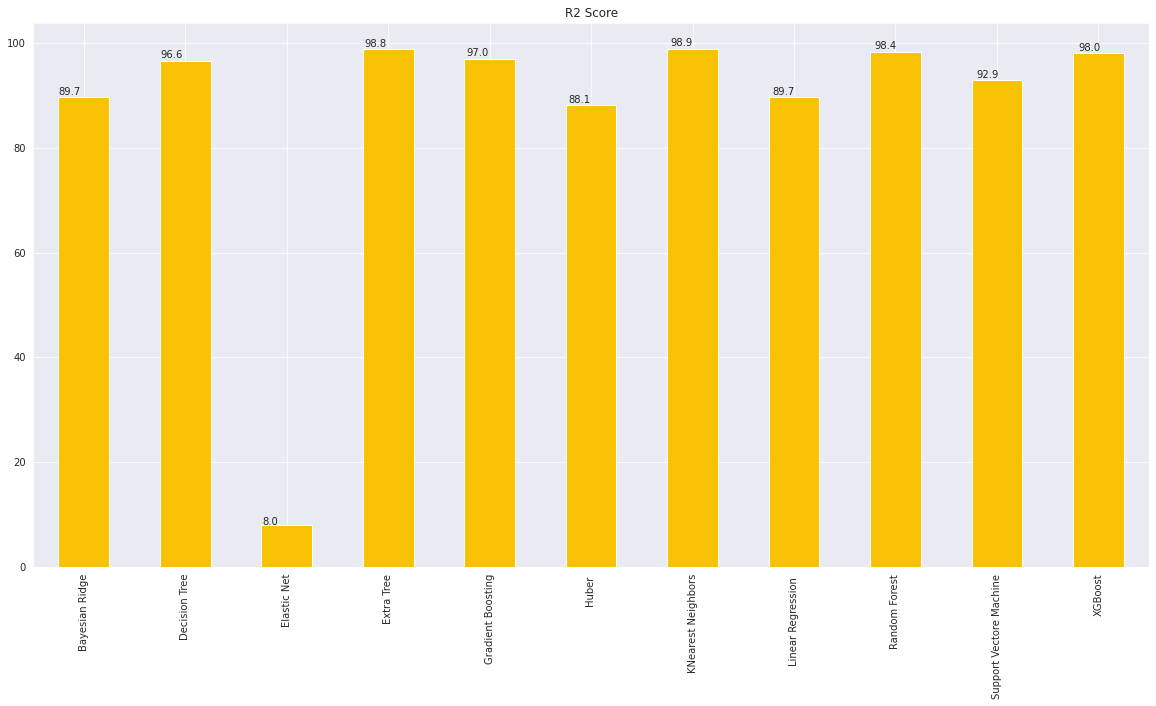

In [44]:
metric_val = {
    "R2 score": {
    "Linear Regression ": lr_score*100,
    "KNearest Neighbors": knn_score*100,
    "Decision Tree": dt_score*100,
    "Bayesian Ridge": br_score*100,
    "Elastic Net": en_score*100,
    "Gradient Boosting": gb_score*100,
    "Huber ": hr_score*100,
    "Support Vectore Machine": svr_score*100,
    "XGBoost": xgb_score*100,
    "Random Forest": rf_score*100,
    "Extra Tree": et_score*100
    }
}

ax = pd.DataFrame(metric_val).plot(kind="bar", 
                             figsize = (20,10), 
                             legend =False, 
                             title = "R2 Score",
                             color = '#FAC205');
                    
for p in ax.patches:
    ax.annotate(str(round(p.get_height(), 1)), (p.get_x() * 1.005, p.get_height() * 1.005))

# Hyperparameter Tuning
---

In [45]:
from sklearn.model_selection import RandomizedSearchCV

n_estimators = [int(x) for x in np.linspace(start = 1, stop = 500, num = 500)]
criterion = ['squared_error', 'absolute_error']
max_depth = [int(x) for x in np.linspace(10, 200, num = 100)]
min_samples_split = [2, 5, 10, 20]
min_samples_leaf = [1, 2, 4, 8]
max_features = [None, 'sqrt', 'log2']
max_leaf_nodes = [int(x) for x in np.linspace(10, 200, num = 100)]
max_depth.append(None)

random_grid = {'n_estimators': n_estimators,
               'criterion':criterion,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'max_leaf_nodes':max_leaf_nodes}
print(random_grid)

{'n_estimators': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 

In [46]:
et = ExtraTreesRegressor()
et_random = RandomizedSearchCV(estimator = et, param_distributions = random_grid, n_iter = 200, cv = 3, verbose=0, random_state=42, n_jobs = -1)
et_random.fit(X_train, y_train)

RandomizedSearchCV(cv=3, estimator=ExtraTreesRegressor(), n_iter=200, n_jobs=-1,
                   param_distributions={'criterion': ['squared_error',
                                                      'absolute_error'],
                                        'max_depth': [10, 11, 13, 15, 17, 19,
                                                      21, 23, 25, 27, 29, 31,
                                                      33, 34, 36, 38, 40, 42,
                                                      44, 46, 48, 50, 52, 54,
                                                      56, 57, 59, 61, 63, 65, ...],
                                        'max_features': [None, 'sqrt', 'log2'],
                                        'max_leaf_nodes': [10, 11, 13, 15, 17,
                                                           19, 21, 23, 25, 27,
                                                           29, 31, 33, 34, 36,
                                                           38,

In [47]:
et_random.best_params_

{'n_estimators': 493,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_leaf_nodes': 194,
 'max_features': None,
 'max_depth': 130,
 'criterion': 'squared_error'}

# Model Evaluation (performance analysis)
---

In [48]:
et_tuned = ExtraTreesRegressor(**et_random.best_params_)
et_tuned.fit(X_train_scaled,y_train)

y_pred_et = et_tuned.predict(X_test_scaled)
r2ett = metrics.r2_score(y_test, y_pred_et)

print("-"*30)
print("Accuracy: ", r2ett)
print("-"*30)

------------------------------
Accuracy:  0.9859128289675241
------------------------------


# Conclusion
---

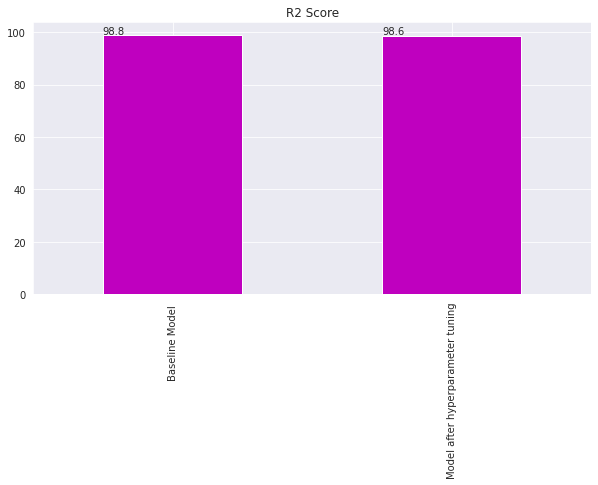

In [49]:
conclusion = {
    "R2 score": {
    "Baseline Model ": et_score*100,
    "Model after hyperparameter tuning": r2ett*100
    }
}

ax = pd.DataFrame(conclusion).plot(kind="bar", 
                             figsize = (10,5), 
                             legend =False, 
                             title = "R2 Score",
                             color = 'm');
                    
for p in ax.patches:
    ax.annotate(str(round(p.get_height(), 1)), (p.get_x() * 1.005, p.get_height() * 1.005))

---